# Defect Calculation Parsing
For parsing defect calculation results with `doped`, we need the following VASP output files
from our bulk and defect supercell calculations:
- `vasprun.xml(.gz)`
- Either:
    - `OUTCAR(.gz)`, if using the Kumagai-Oba (eFNV) charge correction scheme (compatible with isotropic
     or anisotropic (non-cubic) dielectric constants; **recommended**), or
    - `LOCPOT(.gz)`, if using the Freysoldt (FNV) charge correction scheme (isotropic dielectric
    screening only).

Note that `doped` can read the compressed versions of these files (`.gz`/`.xz`/`.bz`/`.lzma`), so we can
 do e.g. `gzip OUTCAR` to reduce the file sizes when downloading and storing these files on our local
 system.

To quickly compress these output files on our HPC, we can run the following from our top-level folder
containing the defect directories (e.g. `Te_i_Te2.83_+2` etc):
```{shell}
for defect_dir in */vasp_*; do cd $defect_dir; gzip vasprun.xml OUTCAR; cd ../..; done
```
(change `OUTCAR` to `LOCPOT` if using the FNV isotropic charge correction), and then download the files
to the relevant folders by running the following from our local system:
```{shell}
for defect_dir in */vasp_*; do cd $defect_dir;
scp [remote_machine]:[path to doped folders]/${defect_dir}/\*gz .;
cd ../..; done
```
changing `[remote_machine]` and `[path to doped folders]` accordingly.

##  Example: CdTe Defect Calculations
In this example, we parse some defect calculations for CdTe. In this case, these
 defects weren't initially generated with `doped`, but this is fine, as `doped` can parse the
 results and automatically determine the defect type and site from the relaxed structure.

```{note}
If you want to use the example outputs shown in this parsing tutorial, you can do so by cloning the `doped` GitHub repository and following the ``dope_parsing_example.ipynb`` Jupyter notebook.
In this case, you will witness some extra warnings during parsing due to some mismatching tags in the bulk/defect outputs – purposely included for testing. 
```
<!--- SK comment: For generating tutorial version, temporarily comment out `if multiple:...` for OUTCAR parsing and comment out "check if same type of charge correction" warning block for multiple corrections  --->

In [3]:
from doped.analysis import DefectsParser
%matplotlib inline 

In [3]:
bulk_path = "CdTe/CdTe_bulk/vasp_ncl"  # path to our bulk supercell calculation
dielectric = 9.13  # dielectric constant (this can be a single number (isotropic), or a 3x1 array or 3x3 matrix (anisotropic))

In [9]:
dp = DefectsParser("CdTe", dielectric=dielectric)  # dielectric needed for charge corrections

Parsing v_Cd_-2/vasp_ncl: 100%|██████████| 7/7 [00:56<00:00,  6.74s/it]               analysis.py:1051: UserWarning: Warning(s) encountered when parsing Int_Te_3_Unperturbed_1 at CdTe/Int_Te_3_Unperturbed_1/vasp_ncl:
There are mismatching INCAR tags for your bulk and defect calculations which are likely to cause severe errors in the parsed results (energies). Found the following differences:
(in the format: (INCAR tag, value in bulk calculation, value in defect calculation)):
[('ADDGRID', True, False)]
The same INCAR settings should be used in both calculations for these tags which can affect energies!

Parsing v_Cd_-2/vasp_ncl: 100%|██████████| 7/7 [00:56<00:00,  8.14s/it]


`DefectsParser` uses multiprocessing by default to speed up parsing when we have many defect supercell calculations to parse. As described in its docstring shown below, it automatically searches the supplied `output_path` for the bulk and defect supercell calculation folders, then automatically determines the defect types, sites (from the relaxed structures) and charge states.

It also checks that appropriate `INCAR`, `KPOINTS`, `POTCAR` settings have been used, and will warn you if it detects any differences that could affect the defect formation energies, as shown in the example above with the mismatching `ADDGRID` tag (here we have manually checked that this choice did not affect the defect formation energies).

In [4]:
DefectsParser?

Init signature:
DefectsParser(
    output_path: str = '.',
    dielectric: Union[float, int, numpy.ndarray, NoneType] = None,
    subfolder: Optional[str] = None,
    bulk_path: Optional[str] = None,
    skip_corrections: bool = False,
    error_tolerance: float = 0.05,
    bulk_bandgap_path: Optional[str] = None,
    processes: Optional[int] = None,
    json_filename: Union[str, bool, NoneType] = None,
)
Docstring:      <no docstring>
Init docstring:
A class for rapidly parsing multiple VASP defect supercell calculations
for a given host (bulk) material.

Loops over calculation directories in `output_path` (likely the same
`output_path` used with `DefectsSet` for file generation in `doped.vasp`)
and parses the defect calculations into a dictionary of:
{defect_name: DefectEntry}, where the defect_name is set to the defect
calculation folder name (_if it is a recognised defect name_), else it is
set to the default `doped` name for that defect. By default, searches for
folders in `output

`doped` automatically attempts
to perform the appropriate finite-size charge correction method for each defect, based on
the supplied `dielectric` constant and calculation outputs, and will
warn you if any required outputs are missing. 

Additionally, the `DefectsParser` class automatically checks the consistency and estimated error of the defect finite-size charge correction, and will warn you if the estimated error is above `error_tolerance` (50 meV by default).  As shown later in the [Charge Corrections](#charge_corrections) section, we can directly visualise the 
finite-size charge correction plots (showing how they are being computed) easily with `doped`, which is 
recommended if any of these warnings about the charge correction accuracy are printed.


With our dictionary of parsed defect entries, we can then query some of the defect-specific results, such as the finite-size charge corrections, the defect site, and energy (without accounting for chemical potentials yet):

In [24]:
for name, defect_entry in dp.defect_dict.items():
    print(f"{name}:")
    if defect_entry.charge_state != 0:  # no charge correction for neutral defects
        print(f"Charge = {defect_entry.charge_state:+} with finite-size charge correction: {list(defect_entry.corrections.values())[0]:+.2f} eV")
    print(f"Supercell site: {defect_entry.defect_supercell_site.frac_coords.round(3)}\n")

Int_Te_3_1:
Charge = +1 with finite-size charge correction: +0.30 eV
Supercell site: [0.801 0.166 0.699]

v_Cd_0:
Supercell site: [0.5 0.5 0.5]

Te_Cd_+1:
Charge = +1 with finite-size charge correction: +0.24 eV
Supercell site: [0.475 0.475 0.525]

Int_Te_3_Unperturbed_1:
Charge = +1 with finite-size charge correction: +0.30 eV
Supercell site: [0.716 0.283 0.871]

Int_Te_3_2:
Charge = +2 with finite-size charge correction: +0.90 eV
Supercell site: [0.835 0.944 0.698]

v_Cd_-1:
Charge = -1 with finite-size charge correction: +0.23 eV
Supercell site: [0. 0. 0.]

v_Cd_-2:
Charge = -2 with finite-size charge correction: +0.74 eV
Supercell site: [0. 0. 0.]


As mentioned in the [defect generation tutorial](https://doped.readthedocs.io/en/latest/dope_workflow_example.html),
we can save `doped` outputs to JSON files and then share or reload them later on, without needing to
re-run the parsing steps above. Here we save our parsed defect entries using the `dumpfn`
function from `monty.serialization`:

In [25]:
from monty.serialization import dumpfn, loadfn
dumpfn(dp.defect_dict, "CdTe_defect_dict.json")  # save parsed defect entries to file

In [26]:
# we can then reload these parsed defect entries from file at any later point with:
CdTe_defect_dict = loadfn("CdTe_defect_dict.json")

## Defect Formation Energy / Transition Level Diagrams

```{tip}
Defect formation energy (a.k.a. transition level diagrams) are one of the key results from a
computational defect study, giving us a lot of information on the defect thermodynamics and electronic behaviour.
```

```{important}
To calculate and plot the defect formation energies, we generate a `DefectPhaseDiagram` object, which
can be created using the `analysis.dpd_from_defect_dict()` function, which takes a dictionary of parsed
defect entries and outputs the `DefectPhaseDiagram`:
```

In [27]:
# generate DefectPhaseDiagram object, with which we can plot/tabulate formation energies, calculate charge transition levels etc:
from doped.analysis import dpd_from_defect_dict
CdTe_example_dpd = dpd_from_defect_dict(dp.defect_dict)
dumpfn(CdTe_example_dpd, "CdTe_example_dpd.json")  # save parsed DefectPhaseDiagram to file, so we don't need to regenerate it later

To calculate and plot defect formation energies, we need to know the chemical potentials of the elements
 in the system (see the [YouTube defects tutorial](https://youtu.be/FWz7nm9qoNg) for more details on
 this).
The workflow for computing and analysing the chemical potentials is described in the [Competing Phases
tutorial](https://doped.readthedocs.io/en/latest/dope_chemical_potentials.html), and here we have already
done this for our CdTe system, so we can just load the results from the JSON file here:

In [28]:
# load CdTe parsed chemical potentials (needed to compute the defect formation energies)
CdTe_chempots = loadfn("CdTe/CdTe_chempots.json")

In [29]:
print(CdTe_chempots)

{'facets': {'Cd-CdTe': {'Cd': -1.01586484, 'Te': -5.7220097228125}, 'CdTe-Te': {'Cd': -2.2671822228125, 'Te': -4.47069234}}, 'elemental_refs': {'Te': -4.47069234, 'Cd': -1.01586484}, 'facets_wrt_el_refs': {'Cd-CdTe': {'Cd': 0.0, 'Te': -1.2513173828125002}, 'CdTe-Te': {'Cd': -1.2513173828125, 'Te': 0.0}}}


Some of the advantages of parsing / manipulating your chemical potential calculations this way, is that:

- You can quickly loop through different points in chemical potential space (i.e. phase diagram facets),
 rather than typing out the chemical potentials obtained from a different method / manually.
- `doped` automatically determines the chemical potentials with respect to elemental references (i.e. chemical potentials are zero in their standard states (by definition), rather than VASP/DFT energies). This is the `facets_wrt_el_refs` entry in the `CdTe_chempots` dict in the cell above.
- `doped` can then optionally print the corresponding phase diagram facet / chemical potential limit and the _formal_ chemical potentials of the elements at that point, above the formation energy plot, as shown in the next cell.

Alternatively, you can directly feed in pre-calculated chemical potentials to `doped`, see below for this.

Basic formation energy plot:

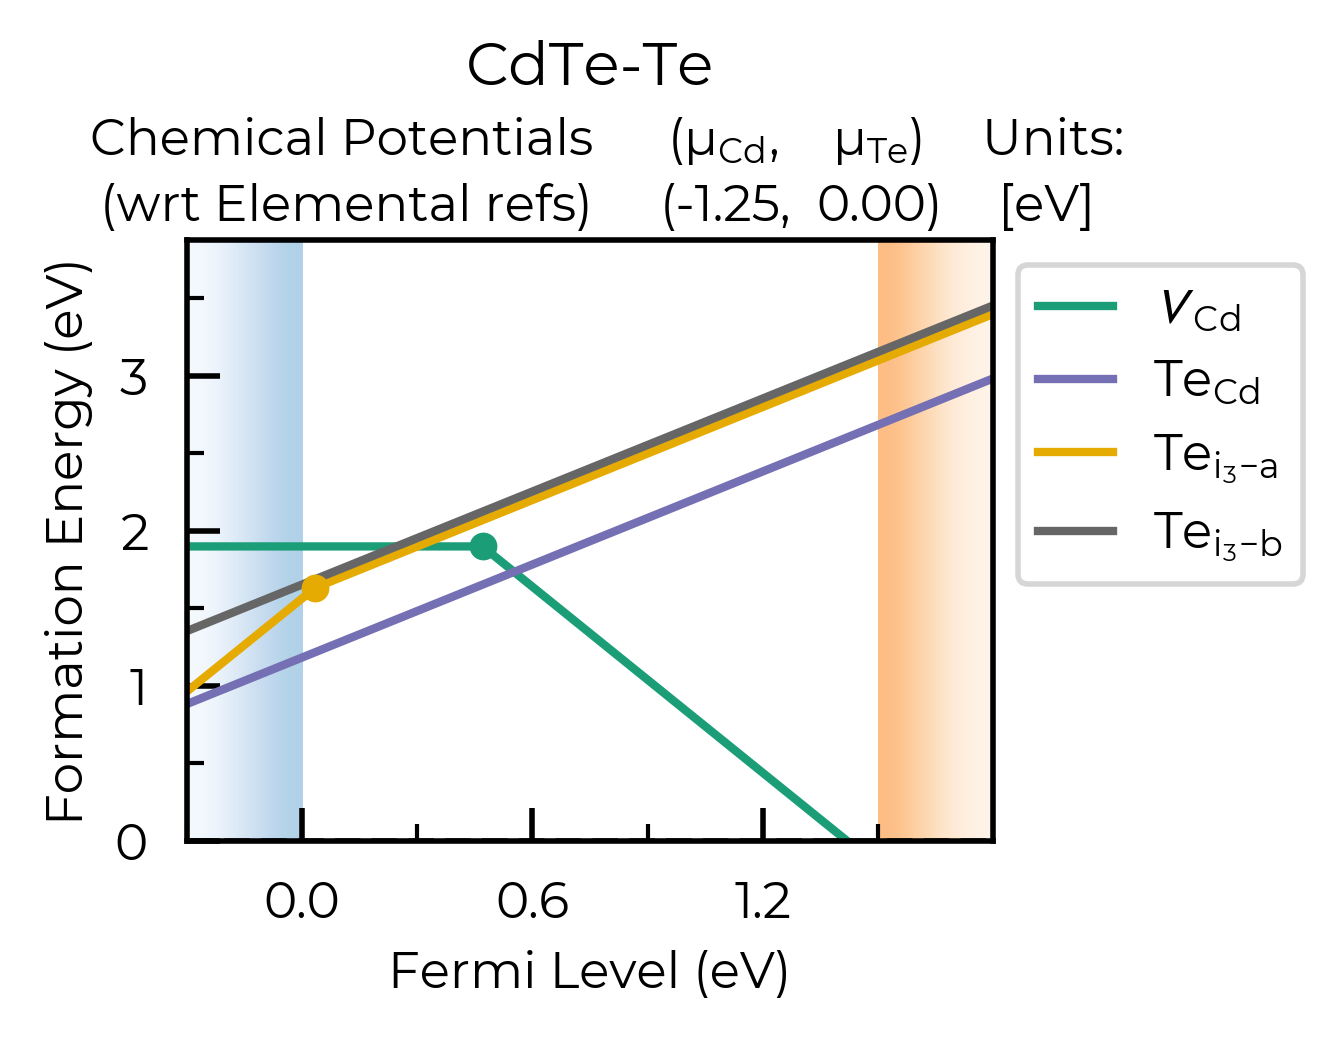

In [30]:
from doped import plotting
def_plot = plotting.formation_energy_plot(
    CdTe_example_dpd,
    CdTe_chempots,
    facets=["CdTe-Te"],
)

There are a lot of options for making the formation energy plot prettier:

In [6]:
# you can run this cell to see the possible arguments for this function:
plotting.formation_energy_plot?
# or go to the python API documentation for this function:
# https://doped.readthedocs.io/en/latest/doped.plotting.html#doped.plotting.formation_energy_plot

Signature:
plotting.formation_energy_plot(
    defect_phase_diagram,
    chempots: Optional[Dict] = None,
    facets: Union[List, str, NoneType] = None,
    el_refs: Optional[Dict] = None,
    chempot_table: bool = True,
    all_entries: Union[bool, str] = False,
    style_file: Optional[str] = None,
    xlim: Optional[Tuple] = None,
    ylim: Optional[Tuple] = None,
    fermi_level: Optional[float] = None,
    colormap: Union[str, matplotlib.colors.Colormap] = 'Dark2',
    auto_labels: bool = False,
    filename: Optional[str] = None,
)
Docstring:
Produce a defect formation energy vs Fermi level plot (a.k.a. a defect
formation energy / transition level diagram). Returns the Matplotlib Figure
object to allow further plot customisation.

Args:
    defect_phase_diagram (DefectPhaseDiagram):
        DefectPhaseDiagram for which to plot defect formation energies
        (typically created from analysis.dpd_from_defect_dict).
    chempots (dict):
        Dictionary of chemical potentials to

Let's plot just the Cd vacancy defects, showing all the charge states and saving to file:

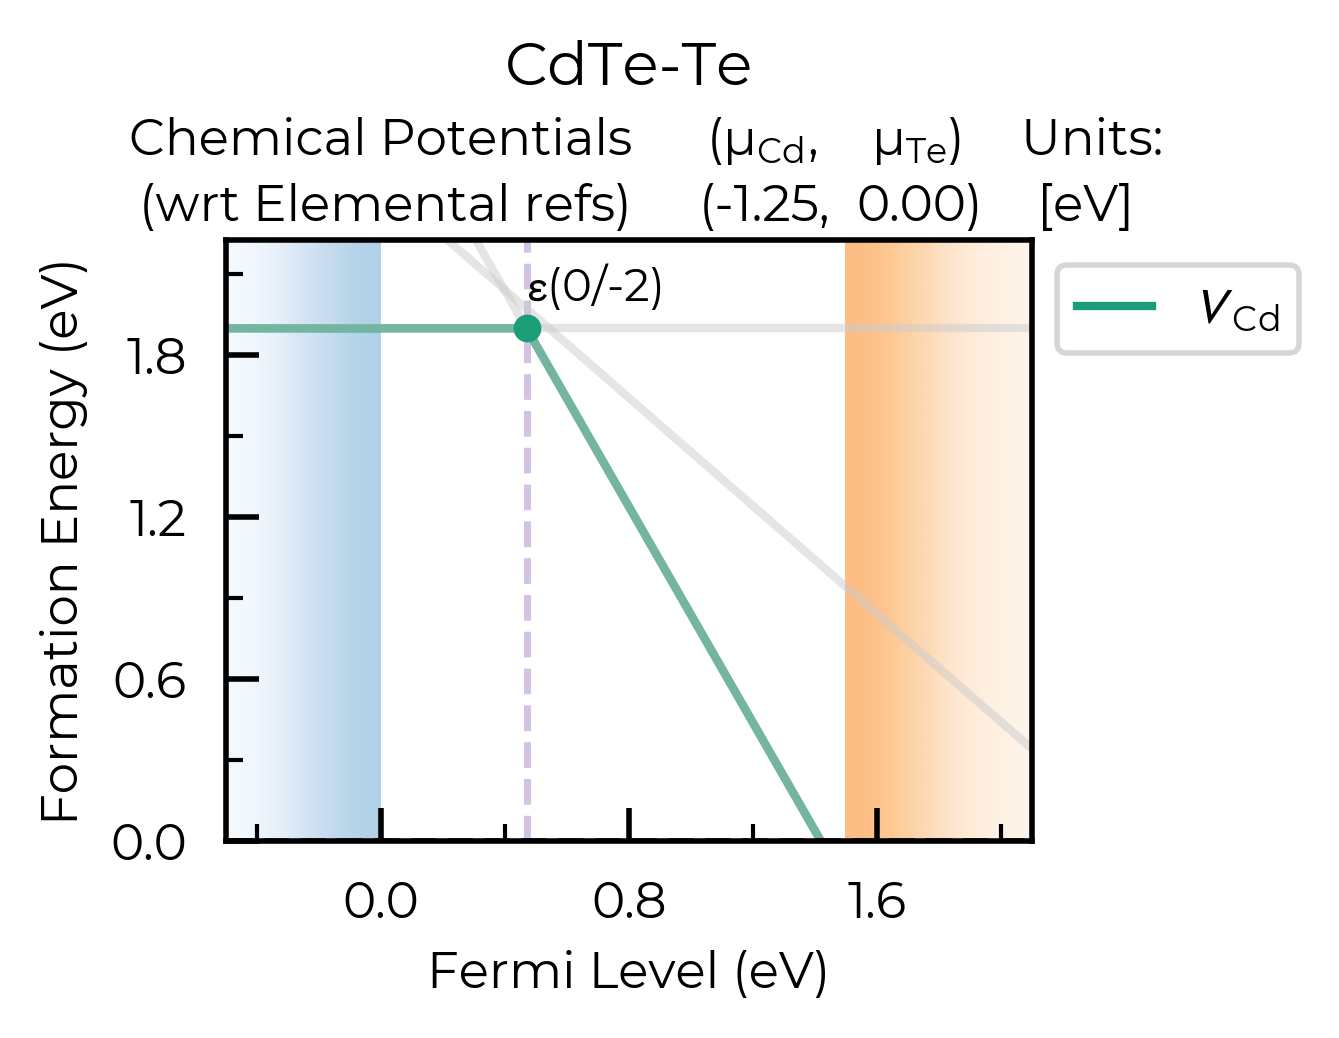

In [42]:
v_Cd_dpd = dpd_from_defect_dict(
    {k: v for k, v in dp.defect_dict.items() if "v_Cd" in k}
)  # only Cd vacancy defects

fig = plotting.formation_energy_plot(
    v_Cd_dpd,
    CdTe_chempots,
    auto_labels=True,
    xlim=(-0.5, 2.1),
    all_entries="faded",
    facets=["CdTe-Te"],
    filename="v_Cd_Te-Rich.pdf",
)
ax = fig.gca()
ax.axvline(0.47, ls="--", c="C4", alpha=0.4, zorder=-1)  # add a vertical line at the transition level

As shown here, `plotting.formation_energy_plot` also returns the `matplotlib` plot object, so you can customise this as much as you like!

#### Manually inputting chemical potentials:

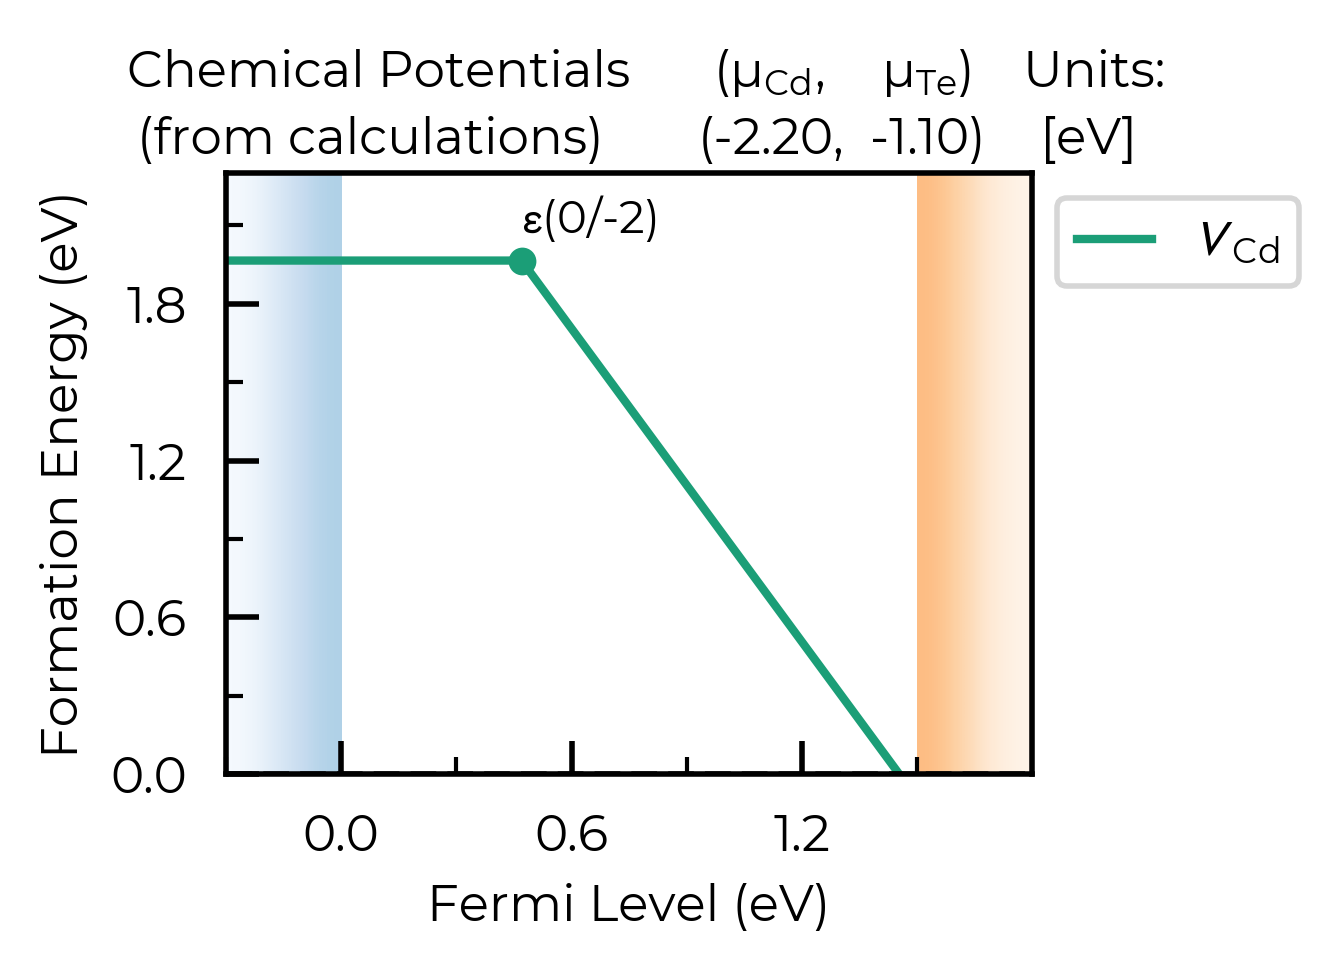

In [44]:
def_plot = plotting.formation_energy_plot(
    v_Cd_dpd,
    chempots = {"Cd": -2.2, "Te": -1.1},
    auto_labels=True,
)

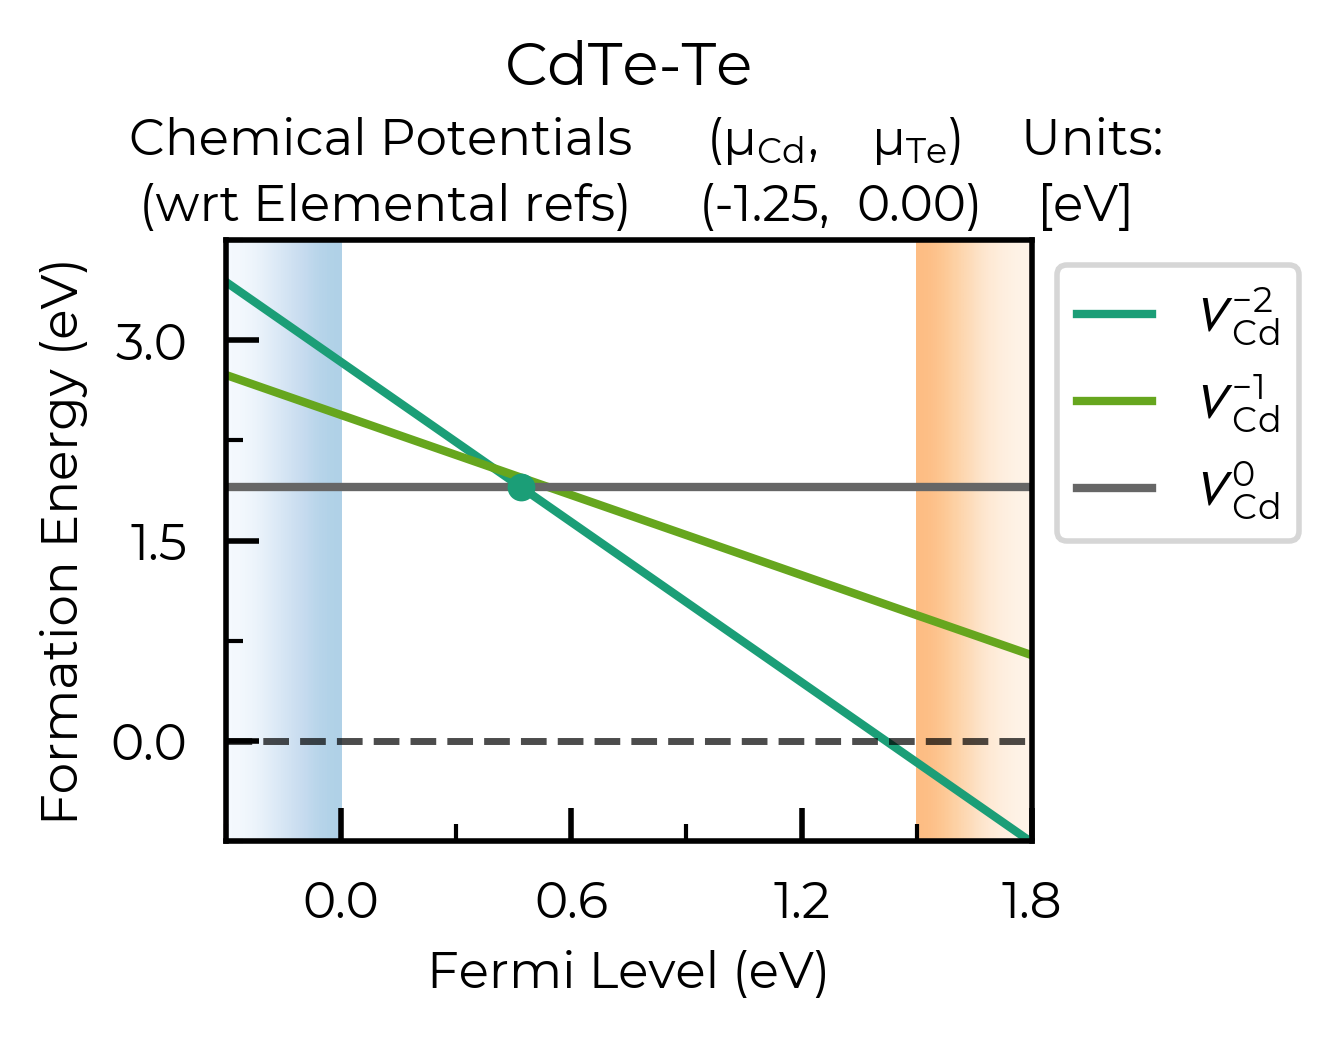

In [45]:
def_plot = plotting.formation_energy_plot(
    v_Cd_dpd,
    CdTe_chempots,
    all_entries=True,  # show the full formation energy lines for all defect charge states
    xlim=(-0.3, 1.8),
    ylim=(-0.75,3.75),  # adjust y-axis
    facets=["CdTe-Te"],
    filename="V_Cd_Te-Rich_All_Lines.pdf"
)

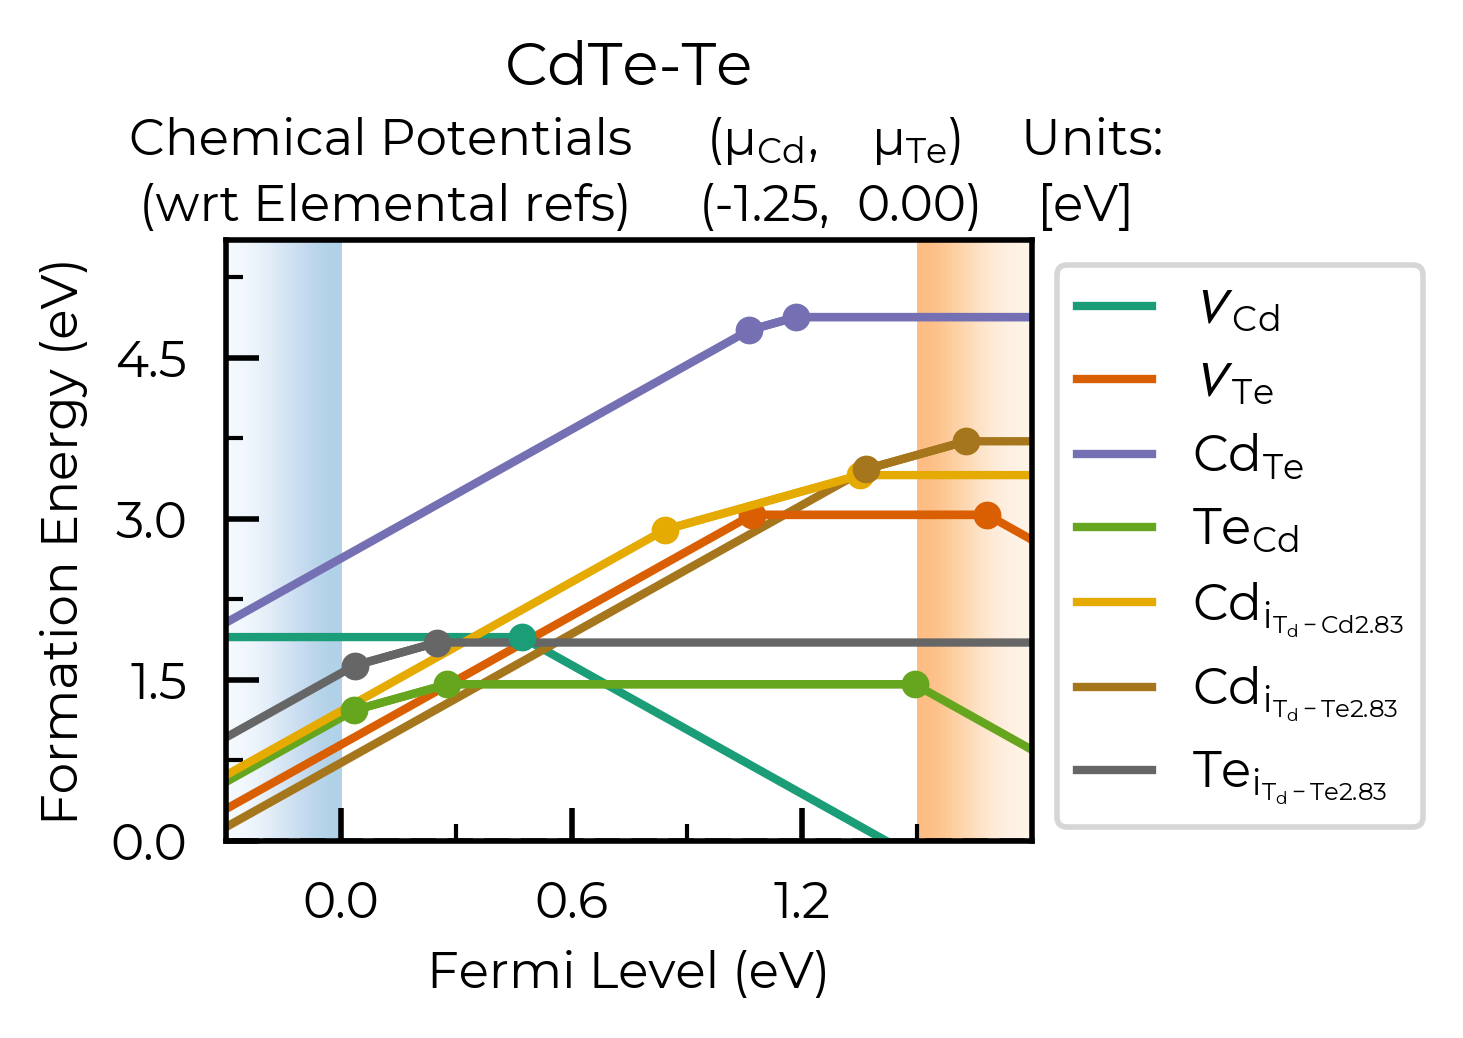

In [47]:
CdTe_defects_dpd = loadfn("../local_doped_testing/CdTe_FNV_dpd_for_plotting.json")

def_plot = plotting.formation_energy_plot(
    CdTe_defects_dpd,
    CdTe_chempots,
    facets=["CdTe-Te"],
)

Nice! Here we can see our different inequivalent sites for the interstitials are automatically labelled
in our plot legend (using the `doped` naming functions), showing that the lowest energy cadmium
interstitial site actually differs between +2 and neutral charge states, as has been noted in this
system in the [literature](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.98.054108).

### Formation Energy Tables

We can also get tables of the defect formation energies (including terms in the formation energy equation,
such as the charge correction and chemical potentials), as shown below:

In [48]:
from doped.analysis import formation_energy_table
formation_energy_df = formation_energy_table(
    v_Cd_dpd,
    CdTe_chempots,
    facets=["CdTe-Te"],  # Te-rich facet
)
formation_energy_df

,Defect,q,ΔEʳᵃʷ,qE_VBM,qE_F,Σμ_ref,Σμ_formal,E_corr,ΔEᶠᵒʳᵐ,Path
0,v_Cd_0,0,4.166,0.000,0,-1.016,-1.251,0.000,1.899,CdTe/v_Cd_0/vasp_ncl
1,v_Cd_-1,-1,6.130,-1.646,0,-1.016,-1.251,0.225,2.441,CdTe/v_Cd_-1/vasp_ncl
2,v_Cd_-2,-2,7.661,-3.293,0,-1.016,-1.251,0.738,2.838,CdTe/v_Cd_-2/vasp_ncl


In [7]:
# you can run this cell to see the possible arguments for this function:
analysis.formation_energy_table?
# or go to the python API documentation for this function:
# https://doped.readthedocs.io/en/latest/doped.analysis.html#doped.analysis.formation_energy_table

Signature:
analysis.formation_energy_table(
    defect_phase_diagram: doped.utils.legacy_pmg.thermodynamics.DefectPhaseDiagram,
    chempots: Optional[Dict] = None,
    el_refs: Optional[Dict] = None,
    facets: Optional[List] = None,
    fermi_level: float = 0,
)
Docstring:
Generates defect formation energy tables (DataFrames) for either a
single chemical potential limit (i.e. phase diagram facet) or each
facet in the phase diagram (chempots dict), depending on the chempots
input supplied. This can either be a dictionary of chosen absolute/DFT
chemical potentials: {Elt: Energy} (giving a single formation energy
table) or a dictionary including the key-value pair: {"facets":
[{'facet': [chempot_dict]}]}, following the doped format. In the
latter case, a subset of facet(s) / chemical potential limit(s)
can be chosen with the facets argument, or if not specified, will
print formation energy tables for each facet in the phase diagram.

Returns the results as a pandas DataFrame or list of

```{tip}
The `formation_energy_table` function returns a list of `pandas.DataFrame` objects (or a single
`DataFrame` object if a certain chemical potential `facet` was chosen), which we can save to csv as
shown below. As a `csv` file, this can then be easily imported to `Microsoft Word` or to `LaTeX` (using
e.g.
<a href="https://www.tablesgenerator.com/latex_tables">https://www.tablesgenerator.com/latex_tables</a>)
 to be included in Supporting Information of papers or
 in theses, which we would recommend for open-science, queryability and reproducibility!
```

In [43]:
formation_energy_df.to_csv(f"V_Cd_Formation_Energies_Te_Rich.csv", index=False)

In [44]:
!head V_Cd_Formation_Energies_Te_Rich.csv

Defect,q,ΔEʳᵃʷ,qE_VBM,qE_F,Σμ_ref,Σμ_formal,E_corr,ΔEᶠᵒʳᵐ,Path
v_Cd_0,0,4.166,0.0,0,-1.016,-1.251,0.0,1.899,CdTe/v_Cd_0/vasp_ncl
v_Cd_-1,-1,6.13,-1.646,0,-1.016,-1.251,0.225,2.441,CdTe/v_Cd_-1/vasp_ncl
v_Cd_-2,-2,7.661,-3.293,0,-1.016,-1.251,0.738,2.838,CdTe/v_Cd_-2/vasp_ncl


Example LaTeX table generated from the above csv file for a thesis:

![image.png](../examples/CdTe/CdTe_LaTeX_formation_energy_table_example.png)

<a id='charge_corrections'></a>
## Analysing Finite-Size Charge Corrections
### Kumagai-Oba (eFNV) Charge Correction Example:

As mentioned above, `doped` can automatically compute either the Kumagai-Oba (eFNV) or Freysoldt (FNV) 
finite-size charge corrections, to account for the spurious image charge interactions in the defect 
supercell approach (see the [YouTube tutorial](https://youtu.be/FWz7nm9qoNg) for more details).
The eFNV correction is used by default if possible (if the required `OUTCAR(.gz)` files are available), 
as it is more general – can be used for both isotropic and
 anisotropic systems – and the numerical implementation is more efficient, requiring smaller file sizes 
 and running quicker.

Below, we show some examples of directly visualising the charge correction plots (showing how they are 
computed), which is recommended if any warnings about the charge correction accuracy are printed when 
parsing our defects (also useful for understanding how the corrections are performed!).

Here we're taking the example of a 
Fluorine-on-Oxygen antisite substitution defect in 
Y<sub>2</sub>Ti<sub>2</sub>O<sub>5</sub>S<sub>2</sub> (a potential photocatalyst and _n_-type thermoelectric), which has a non-cubic anisotropic structure and
 dielectric constant:

In [50]:
from doped.analysis import DefectParser  # can use DefectParser to parse individual defects if desired
F_O_1_entry = DefectParser.from_paths(defect_path="YTOS/F_O_1", bulk_path="YTOS/Bulk",
                                                dielectric = [40.7, 40.7, 25.2]).defect_entry
print(f"Charge: {F_O_1_entry.charge_state:+} at site: {F_O_1_entry.defect_supercell_site.frac_coords}")
print(f"Finite-size charge corrections: {F_O_1_entry.corrections}")

Charge: +1 at site: [0. 0. 0.]
Finite-size charge corrections: {'kumagai_charge_correction': 0.12691248591191384}


Above, the defect has been parsed and the anisotropic (eFNV) charge correction correctly applied, with no warnings thrown. We can directly plot the atomic site potentials which are used to compute this charge correction if we want:
(Though typically we only do this if there has been some warning or error related to the application of the defect charge correction – here we're just showing as a demonstration)

```{note}
Typically we only analyze the charge correction plots like this if there has been some warning
 or error related to the defect charge correction (or to aid our understanding of the underlying 
formation energy calculations). Here we're just showing as a demonstration.
```

Calculated Kumagai (eFNV) correction is 0.127 eV


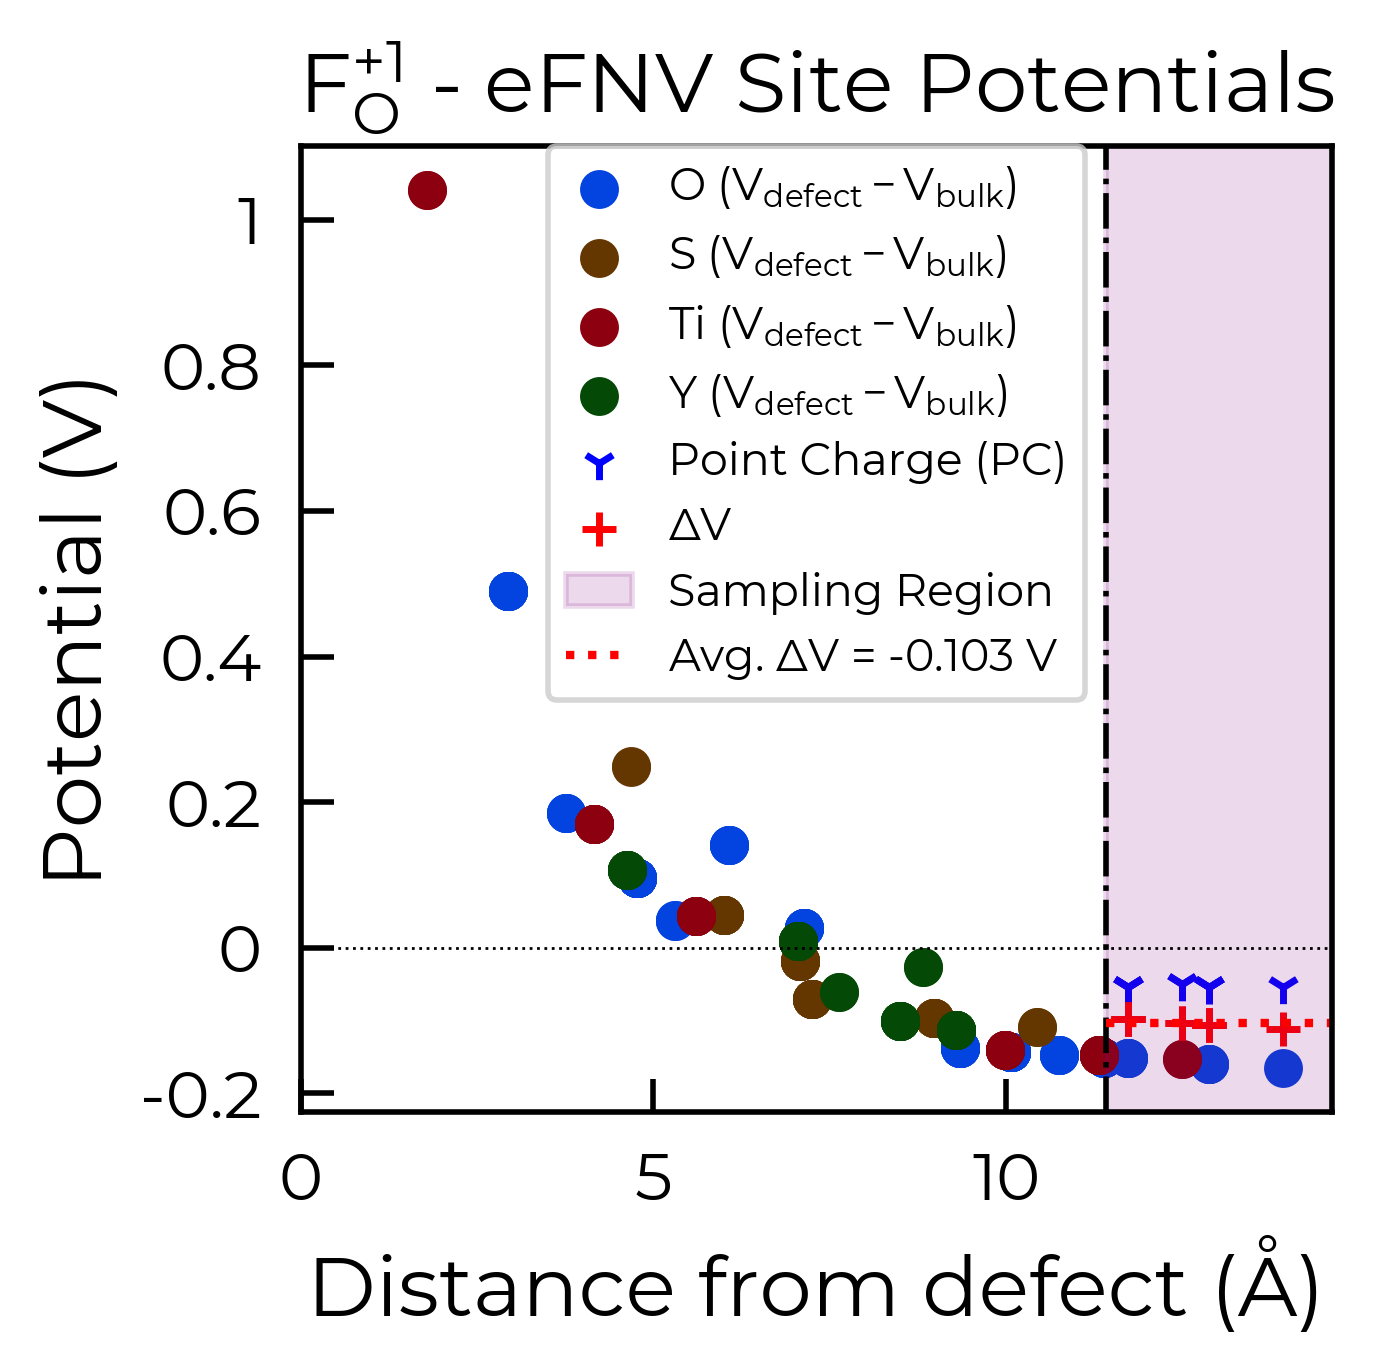

In [51]:
correction, plot = F_O_1_entry.get_kumagai_correction(plot=True)

Here we can see we obtain a good plateau in the atomic potential differences (ΔV) between the 
defect and bulk supercells in the 'sampling region' (i.e. region of defect supercell furthest from the 
defect site), the average of which is used to obtain our potential alignment ('Avg. ΔV') and 
thus our final charge correction term.

If there is still significant variance in the site potential differences in the sampling region (i.e. a 
converged plateau is not obtained), then this suggests that the charge correction may not be as accurate
 for that particular defect or supercell. This error range of the charge correction is automatically 
 computed by `doped`, and can be returned using the `return_correction_error` argument in 
 `get_kumagai_correction`/`get_freysoldt_correction`, or also by adjusting the `error_tolerance` argument: 

In [5]:
correction = F_O_1_entry.get_kumagai_correction(error_tolerance=0.0001)  # extremely strict tolerance, 0.1 meV

Calculated Kumagai (eFNV) correction is 0.127 eV


core.py:215: UserWarning: Estimated error in the Kumagai (eFNV) charge correction for defect F_O_1 is 0.001 eV (i.e. which is than the `error_tolerance`: 0.000 eV). You may want to check the accuracy of the correction by plotting the site potential differences (using `defect_entry.get_kumagai_correction()` with `plot=True`). Large errors are often due to unstable or shallow defect charge states (which can't be accurately modelled with the supercell approach). If this error is not acceptable, you may need to use a larger supercell for more accurate energies.


In [6]:
correction, error = F_O_1_entry.get_kumagai_correction(return_correction_error=True)
error  # calculated error range of 1.3 meV in our charge correction here

Calculated Kumagai (eFNV) correction is 0.127 eV


0.0013276476471274629

### Freysoldt (FNV) Charge Correction Example:

Above, we used the Kumagai-Oba (eFNV) defect image charge correction scheme, which is compatible only 
with both isotropic and anisotropic dielectric screening. 

`doped` also supports the original Freysoldt 
(FNV) charge correction scheme, however this should only be used for _isotropic/cubic host materials_ (and even then 
the eFNV correction is still preferred, being more efficient and robust in implementation). For the FNV 
correction, the `LOCPOT(.gz)` output files must be present in our defect and bulk supercell 
calculation directories.

Calculated Freysoldt (FNV) correction is 0.738 eV


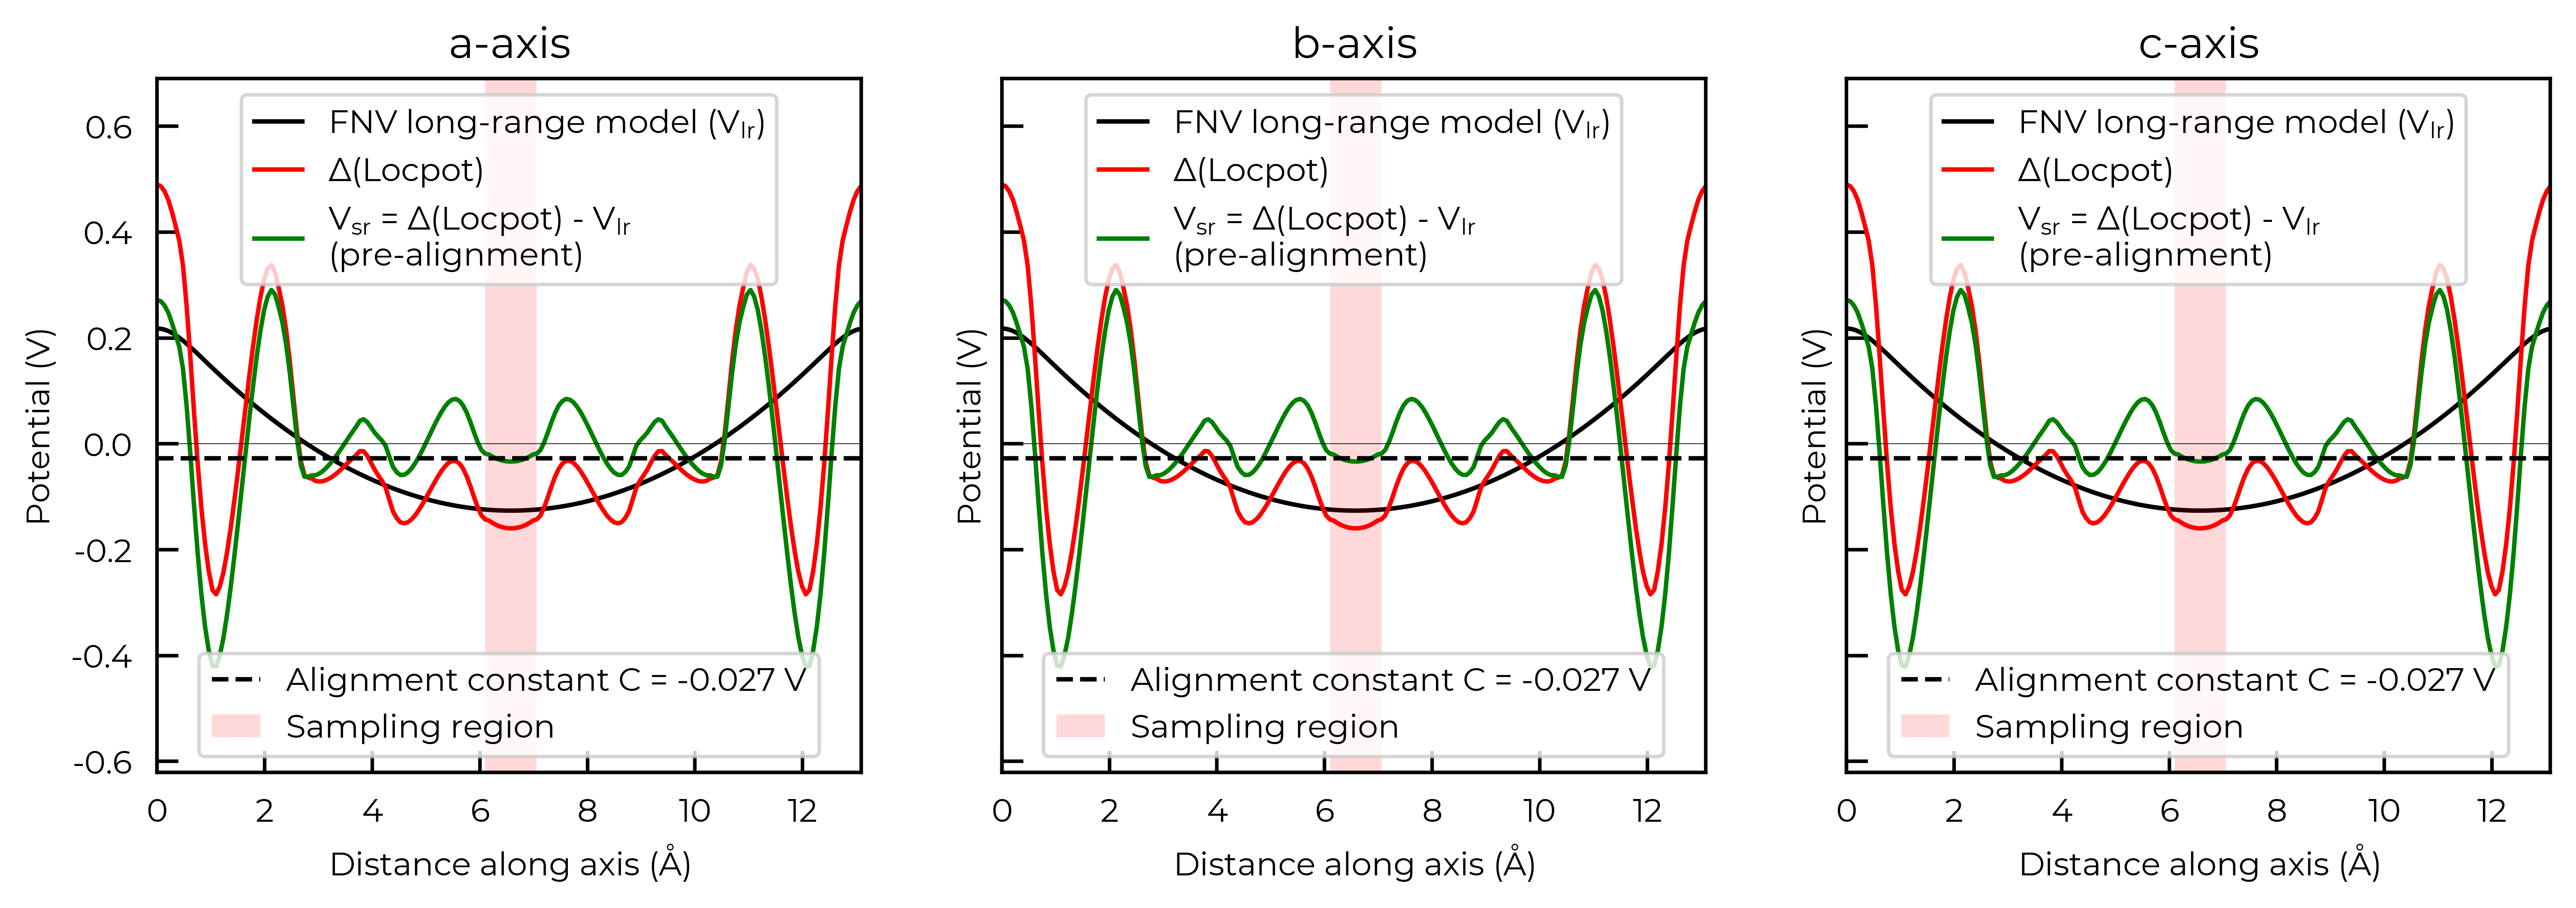

In [52]:
correction, plot = CdTe_defect_dict["v_Cd_-2"].get_freysoldt_correction(plot=True)

## Further Defect Analysis

As briefly discussed in the [YouTube defects tutorial](https://youtu.be/FWz7nm9qoNg), you will likely
want to further analyse the key defect species in your material, by e.g. visualising the relaxed
structures with `VESTA`/`CrystalMaker`, looking at the defect single-particle energy levels using the
[sumo](https://smtg-ucl.github.io/sumo/) DOS plotting functions (`sumo-dosplot`), charge density
distributions (e.g. this [Figure](https://doi.org/10.1021/acsenergylett.1c00380#fig2)).

In particular, you may want to further analyse the behaviour and impact on material properties of your
defects using advanced defect analysis codes such as [py-sc-fermi](https://py-sc-fermi.readthedocs.io/en/latest/) (to analyse defect concentrations, doping and Fermi level tuning), [easyunfold](https://smtg-ucl.github.io/easyunfold/) (to analyse the electronic structure of defects in your
material), or [nonrad](https://nonrad.readthedocs.io/en/latest/) / [CarrierCapture.jl](https://wmd-group.github.io/CarrierCapture.jl/dev/) (to analyse non-radiative electron-hole recombination at defects).
The outputs from `doped` are readily ported as inputs to these codes.

## Further Post-Processing and Correction Analysis

Here we describe some more targeted analysis you can do for your defect calculations (including comparing the relaxed configurations for different initial interstitial positions, structure & bond length analysis of defects, and plotting/analysis of the defect charge corrections), which may be useful for in certain cases.

### Processing Cdᵢ `vasp_gam` calculations to see which site is favoured

In [14]:
import os

bulk_path = "CdTe/CdTe_bulk/vasp_gam/"  # path to bulk (defect-free) supercell calculation
dielectric = 9.13  # calculated dielectric constant, required for computing defect charge corrections
Cd_i_dict = {}  # Keep dictionary of parsed defect entries

for i in os.listdir("CdTe"):
    if 'Cd_i' in i:
        Cd_i_dict[i] = DefectParser.from_paths(
            defect_path=f"CdTe/{i}/vasp_gam/", bulk_path=bulk_path, dielectric=dielectric).defect_entry

for defect_name, defect_entry in Cd_i_dict.items():
    print(f"Name: {defect_name}; Raw Supercell Energy: {defect_entry.get_ediff():.3f} eV")
    # note this energy is just the energy difference of the bulk and defect supercells (including 
    # finite-size charge corrections if any – none here as they're neutral defects), without Fermi
    # level or chemical potential terms (though these are constant for the same defect & charge)

Name: Cd_i_Td_Cd2.83_0; Raw Supercell Energy: 0.592 eV
Name: Cd_i_C3v_0; Raw Supercell Energy: 0.728 eV
Name: Cd_i_Td_Te2.83_0; Raw Supercell Energy: 0.728 eV


Here we see that the Cd-coordinated interstitial site is the lowest energy for _neutral_ cadmium
interstitials here!

```{note}
The energies here do not yet account for the chemical potentials, which are included later in the
post-processing workflow (as shown earlier in this notebook). However, the chemical potential energy
correction is the same for each charge state or site, for a **_given defect_** (e.g. Cd<sub>i</sub>
here) - hence the relative energies are still meaningful here.
```

Here we see that `Cd_i_C3v_0` and `Cd_i_Td_Te2.83_0` have equal final energies (rounded to 1 meV/atom)
suggesting they have relaxed to the same final structure (despite different initial interstitial positions).
Let's use `StructureMatcher` and `local_env` to double-check:

In [24]:
# Here we use the pymatgen StructureMatcher class to compare the relaxed structures of neutral Cd_i:
from pymatgen.analysis.structure_matcher import StructureMatcher
sm = StructureMatcher()
print("Are Cd_i_Td_Cd2.83_0 and Cd_i_C3v_0 final structures the same?:",
      sm.fit(Cd_i_dict['Cd_i_Td_Cd2.83_0'].defect_supercell, Cd_i_dict['Cd_i_C3v_0'].defect_supercell))
print("Are Cd_i_C3v_0 and Cd_i_Td_Te2.83_0 final structures the same?:",
      sm.fit(Cd_i_dict['Cd_i_C3v_0'].defect_supercell, Cd_i_dict['Cd_i_Td_Te2.83_0'].defect_supercell))

Are Cd_i_Td_Cd2.83_0 and Cd_i_C3v_0 final structures the same?: False
Are Cd_i_C3v_0 and Cd_i_Td_Te2.83_0 final structures the same?: True


In [41]:
# we can perform further defect structural analysis with these functions:
from pymatgen.analysis.local_env import CrystalNN
import numpy as np

for key, defect_entry in Cd_i_dict.items():
    # get defect site index in structure: (needed for CrystalNN)
    for i, site in enumerate(defect_entry.defect_supercell.sites):
        if np.isclose(site.frac_coords, defect_entry.defect_supercell_site.frac_coords).all():
            isite = i  # site index, starting from 0

    crystalNN = CrystalNN()
    struct = defect_entry.defect_supercell
    struct.add_oxidation_state_by_guess()
    print("Local order parameters (i.e. resemblence to given structural motif): ",
          crystalNN.get_local_order_parameters(struct, isite))
    print("Nearest-neighbour dictionary: ",
          crystalNN.get_cn_dict(struct, isite))

    bond_lengths = []  # Bond Lengths?
    for i in crystalNN.get_nn_info(struct, isite):
        bond_lengths.append({'Element': i['site'].specie.as_dict()['element'],
                             'Distance': f"{i['site'].distance(struct[isite]):.3f}"})
    print("Bond-lengths (in Angstrom) to nearest neighbours: ", bond_lengths, "\n")

Local order parameters (i.e. resemblence to given structural motif):  None
Nearest-neighbour dictionary:  {'Te0+': 6, 'Cd0+': 4}
Bond-lengths (in Angstrom) to nearest neighbours:  [{'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Cd', 'Distance': '3.007'}, {'Element': 'Cd', 'Distance': '3.007'}, {'Element': 'Cd', 'Distance': '3.007'}, {'Element': 'Cd', 'Distance': '3.007'}] 

Local order parameters (i.e. resemblence to given structural motif):  {'square co-planar': 0.08049643519922586, 'tetrahedral': 0.9999935468913711, 'rectangular see-saw-like': 0.007133072179242341, 'see-saw-like': 0.23547633536015408, 'trigonal pyramidal': 0.24644908542744104}
Nearest-neighbour dictionary:  {'Te0+': 4}
Bond-lengths (in Angstrom) to nearest neighbours:  [{'Element': 'Te', 'Distance': '2.911'}, {'Ele

Here we see the structural similarity of "`Cd_i_C3v_0`" and "`Cd_i_Td_Te2.83_0`", showing that they have
 indeed relaxed to the same structure.
This means we only need to continue with one of these for the more expensive `vasp_std` and `vasp_ncl`
calculations with our full _k_-point mesh.

```{note}
If you want to do this coordination environment analysis with a vacancy, you may have to
introduce a fake atom at the vacancy position, in order to create a `pymatgen` `Site` object, to then use with `CrystalNN`.
For example:
```

In [43]:
from pymatgen.analysis.local_env import CrystalNN
from doped import analysis

for defect_entry in v_Cd_dpd.entries:
    analysis.bold_print(f"{defect_entry.name}, Charge State: {defect_entry.charge_state}")
    crystalNN = CrystalNN(distance_cutoffs=None, x_diff_weight=0.0, porous_adjustment=False, search_cutoff=5)
    struct = defect_entry.defect_supercell.copy()
    struct.append('U', defect_entry.defect_supercell_site.frac_coords) # Add a fake element
    isite = len(struct.sites) - 1 # Starts counting from zero!

    print("Local order parameters (i.e. resemblance to given structural motif): ",
          crystalNN.get_local_order_parameters(struct, isite))
    print("Nearest-neighbour dictionary: ", crystalNN.get_cn_dict(struct, isite))

    bond_lengths = []  # Bond Lengths?
    for i in crystalNN.get_nn_info(struct,isite):
        bond_lengths.append({'Element': i['site'].specie.as_dict()['element'],
                             'Distance': f"{i['site'].distance(struct[isite]):.3f}"})
    print("Bond-lengths (in Angstrom) to nearest neighbours: ",bond_lengths,"\n")

v_Cd_0, Charge State: 0
Local order parameters (i.e. resemblance to given structural motif):  {'square co-planar': 0.1554382566688805, 'tetrahedral': 0.7810051379511412, 'rectangular see-saw-like': 0.052869064285435134, 'see-saw-like': 0.22758740109965894, 'trigonal pyramidal': 0.23528866099223875}
Nearest-neighbour dictionary:  {'Te': 4}
Bond-lengths (in Angstrom) to nearest neighbours:  [{'Element': 'Te', 'Distance': '2.178'}, {'Element': 'Te', 'Distance': '2.605'}, {'Element': 'Te', 'Distance': '2.235'}, {'Element': 'Te', 'Distance': '2.671'}] 

v_Cd_-1, Charge State: -1
Local order parameters (i.e. resemblance to given structural motif):  {'square co-planar': 0.08955199275710107, 'tetrahedral': 0.9980437792997895, 'rectangular see-saw-like': 0.00914205834683717, 'see-saw-like': 0.2561471898083992, 'trigonal pyramidal': 0.2673736880526364}
Nearest-neighbour dictionary:  {'Te': 4}
Bond-lengths (in Angstrom) to nearest neighbours:  [{'Element': 'Te', 'Distance': '2.585'}, {'Element': 